Step 1 - Read full features file

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the features CSV file
file_path = "../../Misc/features_3_sec.csv"
full_features_df = pd.read_csv(file_path)

# Display basic information about the dataset
print(full_features_df.head())         # Display the first few rows
print(full_features_df.info())         # Check for null values and data types
#print(full_features_df.describe())     # Summary statistics for numerical columns


            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

Step 2 - Encode categorical label (genre) on the features file and save

In [2]:
from joblib import dump, load

label_encoder = LabelEncoder()
full_features_df['label'] = label_encoder.fit_transform(full_features_df['label'])

# Encode the categorical label (genre) using LabelEncoder
X = full_features_df.drop(columns=['filename', 'label', 'length'])
y = full_features_df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)



# lets scale the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler and label encoder
dump(scaler, 'scaler.joblib')
dump(label_encoder, 'label_encoder.joblib')

print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
# Print dataset shapes and verify
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing Labels Shape: {y_test.shape}")


Shape of features (X): (9990, 57)
Shape of target (y): (9990,)
Training Features Shape: (7992, 57)
Testing Features Shape: (1998, 57)
Training Labels Shape: (7992,)
Testing Labels Shape: (1998,)


Step 7 - Run XGBoost Classifier on Train and Test

In [3]:
from xgboost import XGBClassifier
import seaborn as sns

# Initialize the XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=29)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
#print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_xgb))



# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.show()


XGBoost Classifier
Accuracy: 91.09%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       208
           1       0.93      0.97      0.95       203
           2       0.81      0.87      0.84       186
           3       0.89      0.90      0.90       199
           4       0.96      0.90      0.93       218
           5       0.88      0.92      0.90       192
           6       0.94      0.96      0.95       204
           7       0.95      0.96      0.96       180
           8       0.93      0.91      0.92       211
           9       0.91      0.84      0.87       197

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



Alternate code for training

c:\MyWork\Tech-Work\SDS\SDS-CP018-music-classifier\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier
Accuracy: 91.59%
Recall: 91.60%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       208
           1       0.93      0.98      0.96       203
           2       0.85      0.88      0.86       186
           3       0.90      0.88      0.89       199
           4       0.94      0.90      0.92       218
           5       0.90      0.93      0.92       192
           6       0.94      0.97      0.96       204
           7       0.94      0.95      0.94       180
           8       0.95      0.91      0.93       211
           9       0.89      0.85      0.87       197

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



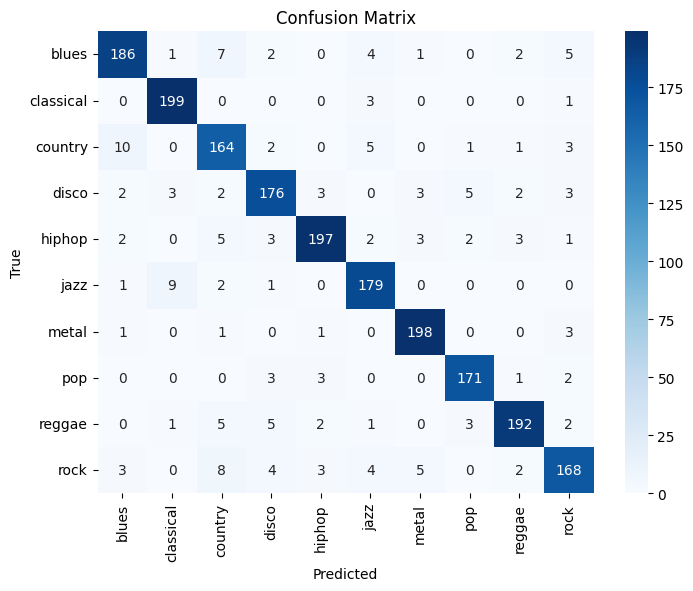


Adjusted Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.12      1.00      0.21       208
           1       0.92      0.99      0.95       203
           2       0.00      0.00      0.00       186
           3       0.00      0.00      0.00       199
           4       0.00      0.00      0.00       218
           5       0.00      0.00      0.00       192
           6       0.00      0.00      0.00       204
           7       0.00      0.00      0.00       180
           8       0.00      0.00      0.00       211
           9       0.00      0.00      0.00       197

    accuracy                           0.20      1998
   macro avg       0.10      0.20      0.12      1998
weighted avg       0.11      0.20      0.12      1998



c:\MyWork\Tech-Work\SDS\SDS-CP018-music-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MyWork\Tech-Work\SDS\SDS-CP018-music-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\MyWork\Tech-Work\SDS\SDS-CP018-music-classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

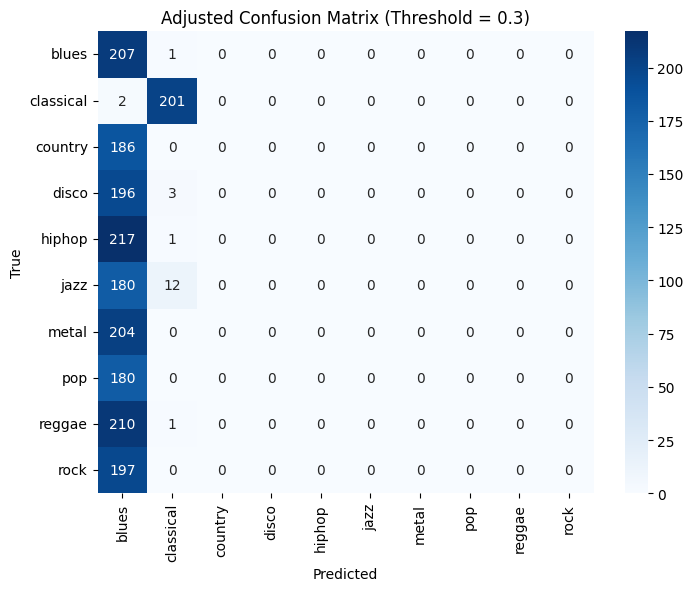

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize the XGBoost model with class imbalance handling
xgb_model = XGBClassifier(
    eval_metric='mlogloss', 
    random_state=29, 
    scale_pos_weight=1,  # Set scale_pos_weight if there's class imbalance (adjust accordingly)
    max_depth=5,         # Tuning hyperparameters for better recall
    learning_rate=0.1,   # Tuning learning rate
    n_estimators=1000    # Number of boosting rounds (trees)
)

# Step 2: Train the model with training data
xgb_model.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Step 4: Evaluate the model using recall
print("XGBoost Classifier")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred_xgb, average='macro') * 100:.2f}%")  # Print recall

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Step 5: Adjust the classification threshold to increase recall
# We will try adjusting the threshold for the positive class to get a better recall.
threshold = 0.3  # Example threshold, you can experiment with different values
y_pred_probs = xgb_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
y_pred_adjusted = (y_pred_probs > threshold).astype(int)  # Adjusted prediction based on threshold

# Step 6: Evaluate adjusted prediction
print("\nAdjusted Classification Report (Threshold = 0.3):")
print(classification_report(y_test, y_pred_adjusted))

# Plot confusion matrix for adjusted threshold
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Adjusted Confusion Matrix (Threshold = 0.3)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



Step 8 - Save the XGBoost Model

In [5]:
from joblib import dump, load

# Save the model to a file
dump(xgb_model, 'genre_class_model_xgboost_full.joblib')




['genre_class_model_xgboost_full.joblib']

Final Step - Test using a sample file

In [6]:
import librosa
import numpy as np
from joblib import load
import pandas as pd

# Step 1: Load the pre-trained XGBoost model, scaler, and label encoder
xgb_model = load('genre_class_model_xgboost_full.joblib')
scaler = load('scaler.joblib')
label_encoder = load('label_encoder.joblib')

# Define the genre names corresponding to the encoded labels
genre_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Step 2: Function to extract all features from a .wav file
def extract_all_features_from_wav(wav_file):
    # Load audio file using librosa
    y, sr = librosa.load(wav_file, sr=None)  # sr=None preserves the original sample rate
    
    # Extract various audio features (matching CSV columns)
    
    # Length of the audio (duration in seconds)
    #length = librosa.get_duration(y=y, sr=sr)
    
    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_var = np.var(spectral_bandwidth)
    
    # Chroma STFT (Short-Time Fourier Transform)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    chroma_stft_var = np.var(chroma_stft)
    
    # RMS (Root Mean Square)
    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_var = np.var(rms)
    
    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_var = np.var(spectral_centroid)
    
    # Roll-off (Spectral roll-off point)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    rolloff_mean = np.mean(rolloff)
    rolloff_var = np.var(rolloff)
    
    # Zero-Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    zero_crossing_rate_var = np.var(zero_crossing_rate)
    
    # Harmony (harmonic-to-noise ratio)
    harmony = librosa.effects.harmonic(y)
    harmony_mean = np.mean(harmony)
    harmony_var = np.var(harmony)
    
    # Perceptual features
    perceptr_mean = np.mean(rms)  # Simplified perceptual mean
    perceptr_var = np.var(rms)    # Simplified perceptual variance
    
    # Tempo (beats per minute)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    
    # MFCCs (Mel-frequency cepstral coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_features = [np.mean(mfcc[i]) for i in range(20)] + [np.var(mfcc[i]) for i in range(20)]
    
    # Combine all extracted features
    features = [
        chroma_stft_mean, chroma_stft_var, rms_mean, rms_var,
        spectral_centroid_mean, spectral_centroid_var, spectral_bandwidth_mean, spectral_bandwidth_var,
        rolloff_mean, rolloff_var, zero_crossing_rate_mean, zero_crossing_rate_var,
        harmony_mean, harmony_var, perceptr_mean, perceptr_var, tempo
    ] + mfcc_features
    
    return features

# Step 3: Extract features from a sample input .wav file
#wav_file = 'klass.00010.wav'  
wav_file ='Staylin_alive.wav'
extracted_features = extract_all_features_from_wav(wav_file)
# un-comment below section for debugging purpose
# print(f"Extracted features (length): {len(extracted_features)}")
# print(f"Extracted features: {extracted_features}")

# Step 4: Get all feature column names from the CSV file
feature_columns = pd.read_csv("../../Misc/features_3_sec.csv").columns.tolist()

# un-comment below section for debugging purpose
#print(f"Feature columns from CSV (length): {len(feature_columns)}")

# Step 5: Clean the feature columns (remove 'label' and 'filename')
feature_columns.remove('label')
feature_columns.remove('filename')
feature_columns.remove('length')

# un-comment below section for debugging purpose
#print(f"Feature columns after cleaning (length): {len(feature_columns)}")

# un-comment below section for debugging purpose
# # Step 6: Compare the number of extracted features to the expected number of features
# if len(extracted_features) != len(feature_columns):
#     print(f"Warning: Number of extracted features ({len(extracted_features)}) does not match the expected number of features ({len(feature_columns)})")
#     print(f"Extracted Features: {extracted_features}")
#     print(f"Feature Columns from CSV: {feature_columns}")
# else:
#     print("Number of extracted features matches the expected columns.")

# un-comment for debugging purpose
#for i in range(len(feature_columns)):
#    print(f"{feature_columns[i]}: {extracted_features[i]}")

# Step 7: Create a DataFrame with the correct columns
extracted_features_df = pd.DataFrame([extracted_features], columns=feature_columns)

# Step 8: Scale the extracted features using the saved scaler
X_scaled = scaler.transform(extracted_features_df)

# Step 9: Use the trained model to predict the genre
predicted_label_encoded = xgb_model.predict(X_scaled)

# Step 10: Decode the predicted label to get the genre name
#predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

# Step 11: Map the encoded label to the actual genre name
predicted_genre_name = genre_names[predicted_label_encoded[0]]  # Map the predicted label to the actual genre name

# Step 12: Print the predicted genre
print(f"The predicted genre of the song {wav_file} is: {predicted_genre_name}")


The predicted genre of the song Staylin_alive.wav is: classical
